# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [2]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=264.44134824877506, mobile=True), User(purchased=False, time_on_site=287.1768945250699, mobile=True), User(purchased=False, time_on_site=230.98221713277152, mobile=False), User(purchased=False, time_on_site=33.12468301708829, mobile=True), User(purchased=False, time_on_site=101.36714568734394, mobile=True), User(purchased=False, time_on_site=68.85602963280755, mobile=True), User(purchased=False, time_on_site=188.49324315265824, mobile=True), User(purchased=False, time_on_site=146.0972374942831, mobile=True), User(purchased=True, time_on_site=159.39097544195553, mobile=True), User(purchased=False, time_on_site=273.6438504400128, mobile=True)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,264.441348,True
1,False,287.176895,True
2,False,230.982217,False
3,False,33.124683,True
4,False,101.367146,True


In [6]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.090855553207938,5.1793454415256415,5.354308395328405,5.367983084448345,5.738568616163598,5.787505509650562,6.370157804866293,6.384852916958624,6.629308992007783,8.550060581378032,...,566.7919573256954,572.7947843103505,573.0517897890105,575.2676728524134,580.9711847707048,586.7297524690397,592.1813557061392,596.4735301527354,596.8479044874965,598.8316782107738
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,0,1,1,0,1,1,1,1,0,...,1,0,1,1,0,0,1,1,1,1
True,1,1,0,0,1,0,0,0,0,1,...,0,1,0,0,1,1,0,0,0,0


In [7]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.497, 123.839]","(123.839, 242.587]","(242.587, 361.335]","(361.335, 480.084]","(480.084, 598.832]"
purchased,,,,,
False,307,277,148,41,41
True,77,66,37,0,6


In [8]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.497, 123.839]","(123.839, 242.587]","(242.587, 361.335]","(361.335, 480.084]","(480.084, 598.832]"
purchased,,,,,
False,0.799479,0.80758,0.8,1.0,0.87234
True,0.200521,0.19242,0.2,0.0,0.12766


In [9]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.916,0.78
True,0.084,0.22


In [10]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

crosstabbed = pd.crosstab([user_data['purchased'], time_bins], user_data['mobile'], normalize='columns')


mobile                        False     True 
purchased time_on_site                       
False     (4.497, 123.839]    0.232  0.332000
          (123.839, 242.587]  0.144  0.321333
          (242.587, 361.335]  0.212  0.126667
          (361.335, 480.084]  0.164  0.000000
          (480.084, 598.832]  0.164  0.000000
True      (4.497, 123.839]    0.012  0.098667
          (123.839, 242.587]  0.028  0.078667
          (242.587, 361.335]  0.020  0.042667
          (361.335, 480.084]  0.000  0.000000
          (480.084, 598.832]  0.024  0.000000

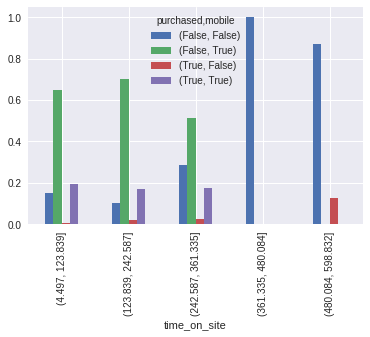

In [20]:
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='index').plot(kind = 'bar', stacked = False);

In [0]:
X1 = user_data['mobile']
X2 = user_data[]
Y
fig, ax = plt.subplots()
ax.plot(X,Y,'o')
ax.plot(X,Y,'x')
plt.show()

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

person_data = pd.read_csv('https://raw.githubusercontent.com/edwardauron/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')

person_data.head()

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


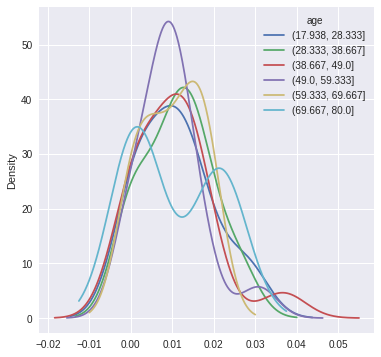

In [116]:
# split the data into very small bins to remove clutter from scatterplot above 
# but to still allow a somewhat detailed look at variable relationships
%matplotlib inline
exercise_bin = pd.cut(person_data['exercise_time'], 4)
weight_bin = pd.cut(person_data['weight'], 4)
age_bin = pd.cut(person_data['age'], 6)


exercise_weight_crossed_age = pd.crosstab([exercise_bin, weight_bin], 
        age_bin, normalize='all')

exercise_weight_crossed_age.plot(kind = 'kde', figsize=(6, 6));

# From Wikipedia: a probability density function (PDF), or density of a 
# continuous random variable, is a function, whose value at any given sample
# in the sample space (the set of possible values taken by the random variable) 
# can be interpreted as providing a relative likelihood that the value of the 
# random variable would equal that sample.

# for each age bin, let bin represent it's own variable in and we use 
# a KDE to predict the probability of an age group's likelyhood to be there.

# sadly i do not think this implementation supports multivariable situations

# TODO: find or implement KDE solution with multivariables

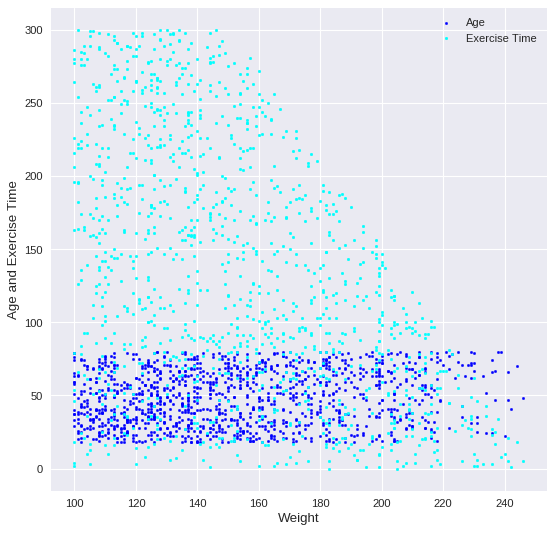

In [122]:
fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111)

ax1.scatter(person_data['weight'], person_data['age'], s=5,
            c='b', marker="o", label='Age')

ax1.scatter(person_data['weight'] ,person_data['exercise_time'],
            s=6, c='cyan', marker="o", label='Exercise Time')

plt.ylabel('Age and Exercise Time', fontsize=12)
plt.xlabel('Weight', fontsize=12)
plt.legend(loc='best');
plt.show()

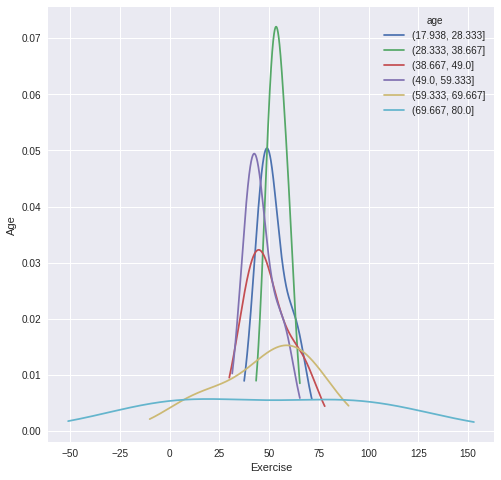

In [117]:
exercise_by_age = pd.crosstab(exercise_bin, age_bin)

ax = exercise_by_age.plot(kind = 'kde', figsize=(8, 8), grid=True)
ax.set(xlabel="Exercise", ylabel="Age");


# now this is pretty neat, for the most part there is a great variety of 
# possability in exercise habits for the age groups
# however for 69-80 bin they have a relatively stable density
# which founds the hypothesis that perhaps there are particular 
# exercise habits that can lead to old age, or that old age restricts 
# to specific habits.



In [112]:
exercise_by_age.head()

age,"(17.938, 28.333]","(28.333, 38.667]","(38.667, 49.0]","(49.0, 59.333]","(59.333, 69.667]","(69.667, 80.0]"
exercise_time,,,,,,
"(-0.3, 75.0]",0.129577,0.169014,0.118310,0.112676,0.183099,0.287324
"(75.0, 150.0]",0.148256,0.142442,0.145349,0.130814,0.188953,0.244186
"(150.0, 225.0]",0.241379,0.210728,0.160920,0.160920,0.180077,0.045977
"(225.0, 300.0]",0.204167,0.220833,0.275000,0.237500,0.062500,0.000000


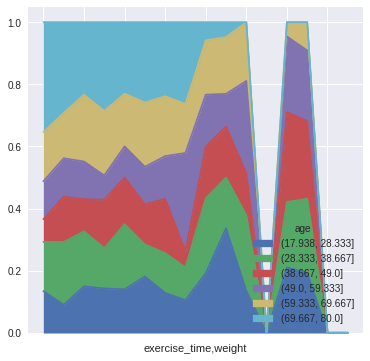

In [77]:
exercise_weight_crossed_age.plot(kind = 'area', figsize=(6, 6));

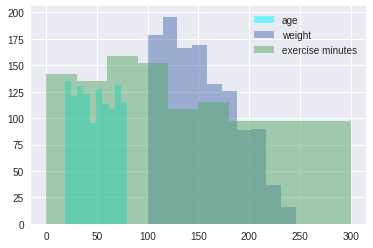

In [166]:
from matplotlib import pyplot



age_weight_df = pd.concat([person_data['age'], person_data['weight'], 
                           person_data['exercise_time']], axis=1, 
                           keys=['age', 'weight', 'exercise'])


bins = np.linspace(-10, 10, 100)
x = age_weight_df['age']
y = age_weight_df['weight']
z = age_weight_df['exercise']

plt.hist(x, alpha=0.5, color='cyan', label='age')
plt.hist(y, alpha=0.5, label='weight')
plt.hist(z, alpha=0.5, label='exercise minutes')

pyplot.legend(loc='upper right')
pyplot.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data? 

*The time and weight variables are continuous while age is discrete.*


2.  What are the relationships between the variables?

*negative correlation between exercise and weight, and a slight negative correlation between weight and age.*

3.  Which relationships are "real", and which spurious? 

*It's hard to say without accounting for other factors. 
There is certainly scientific evidence that shows consistent exercise and a moderate weight are key to longevity, 
but we are missing many variables in this specific data set, such as height, BMI, diet, climate, ethnicity, and further down that train of thought genetic expression and how said expression holds up against so many many factors. On that thought there is no conclusive evidence any of these relationships are real because the lacking information is so immense. I think you have to get into the really nitty gritty. Like, how are mitchondrial processes and telomere length effected by weight and exercise before establishing any 'Real' relationships, but a correlation indictates that there is possability, so it's a positive sign to seek those lacking variables and supplement with more detailed information to further explore the relationship. *
*But then you have an even further problem, which is that knowing there is further analysis needed is only possible by pre-existing knowledge of other variables. How do you address that when dealing with a specific data set, or say you studied something brand new, how do you gain knowledge of said variables. I do not know.*

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)